# **Helmholtz PDE example : cas (d)**

## *Discussion sur les formulations*
Type guide d'onde avec : $\Omega = [-L, L] \times [-h, h]$

Formulation sur le site du projet :
\begin{align*}
& -\Delta \varphi(x) - \omega^2 \, \varphi(x) = f(x) \quad \text{in} \enspace \Omega\\
& \varphi = 0 \quad \text{on} \enspace \{ x = \pm h \} \cup \{ y = -L \} := \partial \Omega\\
& \partial_n \varphi - ik \varphi = 0 \quad \text{on} \enspace \partial \Omega
\end{align*}

Condition de Robin: Cette condition est plus générale que la condition de Neumann et permet de modéliser des pertes d'énergie à la frontière. <br>
Le paramètre k contrôle le degré de perte:<br>
- k=0 correspond à la condition de Neumann pure (pas de perte).<br>
- k>0 correspond à des pertes d'énergie (absorption).<br>
- k<0 correspond à un gain d'énergie (amplification).<br>

---> Pas sûr que cette formulation soit bonne. Dans la dernière condition $\varphi$ est nulle.
<!-- Exemples de sources:  -->
<!-- - 1) Considérons une fonction source de la forme $f(x,y)=sin(kx)sin(ly)$. <br>
    ==> (A VERIFIER ! (gemini) ) En utilisant la méthode de séparation des variables, on trouve:
    $φ(x,y)=∑\_n∑\_m ​A_{mn}.cos(kx)cos(ly).e^{−β_{mn}z} $
    où
    $\partial_n \varphi - ik\varphi = 0$ on  $\partial \Omega$ ==> $\frac{l}{h} = tan(kh)$ <br>

    TO BE CORRECTED -->

<br>

#### Formulation alternative mais **pas sûrement bonne** (avec une Cste non nulle pour éviter la sol nulle) : <br>
$\Omega = [-L, L] \times [-h, h]$
\begin{align*}
& \Delta \varphi(x,y) + k^2 \, \varphi(x,y) = 0 \quad \text{in} \enspace \Omega \\
& \varphi = Cste \quad \text{on} \enspace \{ x = \pm L \} \\
& \partial_n \varphi + \alpha . \varphi = 0 \quad \text{on} \enspace \{ y = \pm h \}
\end{align*}
<br>

## *Formulation retenue pour le code suivant (source cste non nulle)*:

\begin{align*}
& -\Delta \varphi(x) - \omega^2 \, \varphi(x) = 1 \quad \text{in} \enspace \Omega\\
& \varphi = 0 \quad \text{on} \enspace \{ x = \pm h \} \cup \{ y = -L \} := \partial \Omega\\
& \partial_n \varphi = 0 \quad \text{on} \enspace \partial \Omega
\end{align*}

(à tenter : source cste complexe non réelle.. ensuite source variable)

## General imports

In [83]:
from PIL import Image

import os
from collections import namedtuple
from abc import ABC, abstractmethod
import numpy as np
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import tqdm

## Ma tentative

### Mesh & Collocation points

In [84]:
import numpy as np

def generate_uniform_mesh(L, h, Nx, Ny):
    x_points = np.linspace(-L, L, Nx)
    y_points = np.linspace(-h, h, Ny)
    mesh_points = np.array(np.meshgrid(x_points, y_points)).T.reshape(-1, 2)
    return mesh_points

# Example parameters
L = 1.0
h = 0.5
Nx = 30
Ny = 15

# Generate uniform mesh
collocation_points = generate_uniform_mesh(L, h, Nx, Ny)
# print("Collocation points:", collocation_points)
print("shape of the mesh:", collocation_points.shape)

# Calculate the number of colocation points
number_of_colocation_points = collocation_points.shape[0]
print("Number of colocation points:", number_of_colocation_points)

import torch
# Extract x and y coordinates from collocation_points
x_points = collocation_points[:, 0]
y_points = collocation_points[:, 1]

# Determine the boundary indices
boundary_indices = torch.arange(number_of_colocation_points)[
    (x_points == -L) | (x_points == L) | (y_points == -h) | (y_points == h)
]

print("Boundary indices:", boundary_indices)

shape of the mesh: (450, 2)
Number of colocation points: 450
Boundary indices: tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  29,  30,  44,  45,  59,  60,  74,  75,  89,  90, 104, 105,
        119, 120, 134, 135, 149, 150, 164, 165, 179, 180, 194, 195, 209, 210,
        224, 225, 239, 240, 254, 255, 269, 270, 284, 285, 299, 300, 314, 315,
        329, 330, 344, 345, 359, 360, 374, 375, 389, 390, 404, 405, 419, 420,
        434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447,
        448, 449])


### NN Architechture + Loss computation ; **Have to check the boundary loss (it gives 'nan' total loss once uncommented)** !

In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad

# Define the MLP architecture
class ComplexMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ComplexMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.layers(x)

In [86]:
# Define the loss function incorporating the Helmholtz equation and boundary conditions

def physics_loss(model, x, true_boundary_data, boundary_indices):
    # Compute predictions for all points
    predictions = model(x)
    # predictions.requires_grad = True

    # Extract real and imaginary parts pf predictions
    u_real, u_imag = torch.chunk(predictions, 2, dim=1)

    # Compute derivatives
    grad_u_real = grad(u_real, x, grad_outputs=torch.ones_like(u_real), create_graph=True)[0]
    grad_u_imag = grad(u_imag, x, grad_outputs=torch.ones_like(u_imag), create_graph=True)[0]
    laplacian_u_real = torch.sum(grad(grad_u_real, x, grad_outputs=torch.ones_like(grad_u_real), create_graph=True)[0], dim=1)
    laplacian_u_imag = torch.sum(grad(grad_u_imag, x, grad_outputs=torch.ones_like(grad_u_imag), create_graph=True)[0], dim=1)

    # Calculate the residual of the Helmholtz equation
    residual = laplacian_u_real + laplacian_u_imag + k_squared * (u_real + u_imag) + 1    # because I have assume a constant source function f = 1


    # Compute the normal derivatives at boundary points
    dudx = grad(u_real, x, grad_outputs=torch.ones_like(u_real), create_graph=True)[0][:, 0]
    dudy = grad(u_real, x, grad_outputs=torch.ones_like(u_real), create_graph=True)[0][:, 1]
    dvdx = grad(u_imag, x, grad_outputs=torch.ones_like(u_imag), create_graph=True)[0][:, 0]
    dvdy = grad(u_imag, x, grad_outputs=torch.ones_like(u_imag), create_graph=True)[0][:, 1]
    # grad_u_mag = torch.sqrt(grad_u_real**2 + grad_u_imag**2)  # Magnitude of the whole gradient (not only the normal derivative)

    # Compute normal derivatives based on boundary direction
    normal_derivatives_x = (dudx * (x[:, 0] == -L) - dudx * (x[:, 0] == L)) + (dvdx * (x[:, 0] == -L) - dvdx * (x[:, 0] == L))
    normal_derivatives_y = (dudy * (x[:, 1] == -h) - dudy * (x[:, 1] == h)) + (dvdy * (x[:, 1] == -h) - dvdy * (x[:, 1] == h))
    normal_derivatives = torch.sqrt(normal_derivatives_x**2 + normal_derivatives_y**2)  # Magnitude of the normal derivatives


    # Extract predictions for boundary points
    boundary_predictions = predictions[boundary_indices, :]

    # Enforce boundary conditions
    boundary_loss_1 = torch.mean((boundary_predictions - true_boundary_data)**2)       # Mean squared error
    boundary_loss_2 = torch.mean(normal_derivatives)                                   # Penalty on normal derivative
    # boundary_loss_2 = torch.mean(grad_u_mag[boundary_indices]**2)                    # si jamais on veut que la dérivée de u soit nulle et pas seulement la dérivé normale

    boundary_loss = boundary_loss_1 + boundary_loss_2                                  #TO check


    # Total loss
    total_loss = torch.mean(torch.square(residual)) #+ boundary_loss                   # Loss_residuelle + loss_boundary_1 + loss_boundary_2   (JE DOIS AJOUTER DES COEFFS une fois que ça marche)
    return total_loss


### Predicting the solution (still needs some debugging of required grads...)

In [87]:
# Move the data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
input_dim = 2 #*number_of_colocation_points     #according to the mesh of the set [-L,L].[-h,h] (the number of points) !
hidden_dim = 512  # to adapt
output_dim = 2 #input_dim    #the model returns a 2D_tensor of two vectors : u_real and u_imag predictions on every colocation point
# Define other parameters

k_squared = 1e2  # Wave number squared in Helmholtz equation (O.G de k --> 10^3 en acoustique VS 10^6 en éléctromagnétique)
model = ComplexMLP(input_dim, hidden_dim, output_dim).to(device)



# Generate true boundary data
true_boundary_data = torch.zeros((len(boundary_indices), 2), device=device, requires_grad=True)   # assuming null Dirichlet boundary conditions for both u and derivée_normale(u)
# Reshape collocation_points to match the input shape expected by the model
collocation_points = torch.tensor(collocation_points, dtype=torch.float32, device=device, requires_grad=True)
# collocation_points = collocation_points.unsqueeze(0)  # Add a batch dimension
# collocation_points = collocation_points.expand(1, number_of_colocation_points, 2).reshape(-1, input_dim)
collocation_points = collocation_points.unsqueeze(0)  # Add a batch dimension
collocation_points = collocation_points.expand(-1, number_of_colocation_points, -1).reshape(-1, input_dim)

boundary_indices = boundary_indices.to(device)
# boundary_indices.requires_grad = True    #type int can't require grad

In [88]:
# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
losses = []

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = physics_loss(model, collocation_points, true_boundary_data, boundary_indices)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())  # Append the current loss to the list
    if epoch==1 or (epoch+1)%20==0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.3f}")

Epoch 2/1000, Loss: 5251.684
Epoch 20/1000, Loss: 140.922
Epoch 40/1000, Loss: 12.859
Epoch 60/1000, Loss: 1.437
Epoch 80/1000, Loss: 0.354
Epoch 100/1000, Loss: 0.105
Epoch 120/1000, Loss: 0.043
Epoch 140/1000, Loss: 0.032
Epoch 160/1000, Loss: 0.024
Epoch 180/1000, Loss: 0.019
Epoch 200/1000, Loss: 0.016
Epoch 220/1000, Loss: 0.013
Epoch 240/1000, Loss: 0.012
Epoch 260/1000, Loss: 0.010
Epoch 280/1000, Loss: 0.009
Epoch 300/1000, Loss: 0.008
Epoch 320/1000, Loss: 0.007
Epoch 340/1000, Loss: 0.007
Epoch 360/1000, Loss: 0.006
Epoch 380/1000, Loss: 0.006
Epoch 400/1000, Loss: 0.005
Epoch 420/1000, Loss: 0.005
Epoch 440/1000, Loss: 0.005
Epoch 460/1000, Loss: 0.004
Epoch 480/1000, Loss: 0.004
Epoch 500/1000, Loss: 0.004
Epoch 520/1000, Loss: 0.004
Epoch 540/1000, Loss: 0.004
Epoch 560/1000, Loss: 0.003
Epoch 580/1000, Loss: 0.003
Epoch 600/1000, Loss: 0.003
Epoch 620/1000, Loss: 0.003
Epoch 640/1000, Loss: 0.003
Epoch 660/1000, Loss: 0.003
Epoch 680/1000, Loss: 0.003
Epoch 700/1000, Loss

### Plotting the solution:

In [89]:
import numpy as np
import matplotlib.pyplot as plt

x_points = collocation_points[:, 0]
y_points = collocation_points[:, 1]

# Reshape x_points and y_points to match the original grid
x_points = x_points.reshape((Nx, Ny))
y_points = y_points.reshape((Nx, Ny))

# # Transpose x_points and y_points to match the expected shape for meshgrid
# x_points = x_points.T
# y_points = y_points.T


# Evaluate the model on the collocation points
model.eval()
with torch.no_grad():
    predictions = model(torch.tensor(collocation_points, dtype=torch.float32))

# Compute the magnitude of the complex-valued function U
U_real, U_imag = torch.chunk(predictions, 2, dim=1)
U_magnitude = torch.sqrt(U_real**2 + U_imag**2).numpy()

# Reshape the magnitude to match the shape of the collocation points
# U_magnitude_plot = U_magnitude.reshape((-1, Ny, Nx))
U_magnitude_plot = U_magnitude.reshape((Nx, Ny))

/tmp/ipykernel_34/247393141.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = model(torch.tensor(collocation_points, dtype=torch.float32))


In [94]:
print('U_magnitude_plot:', U_magnitude_plot.shape, "; x_points:", x_points.shape)
X, Y = np.meshgrid(x_points.detach(), y_points.detach())
print(X.shape)

U_magnitude_plot: (30, 15) ; x_points: torch.Size([30, 15])
(450, 450)


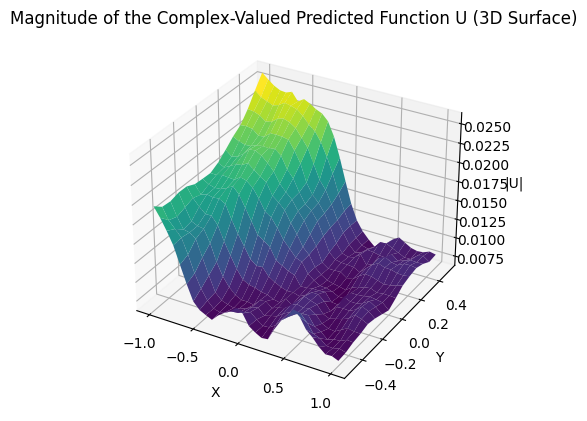

In [98]:
# Plot the 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = x_points.detach(), y_points.detach()
ax.plot_surface(X, Y, U_magnitude_plot, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('|U|')
ax.set_title('Magnitude of the Complex-Valued Predicted Function U (3D Surface)')
plt.show()

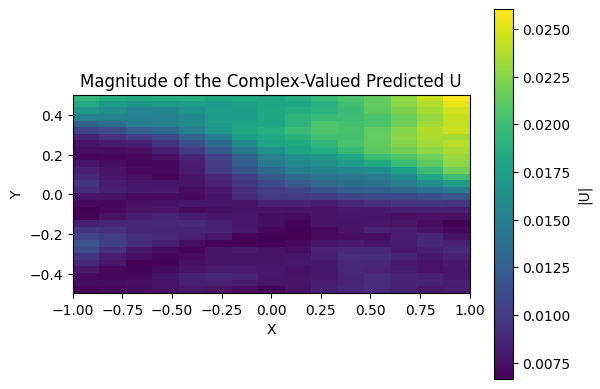

In [102]:
# # Plot the heat map
# plt.figure()
# plt.imshow(U_magnitude_plot[0], extent=[-L, L, -h, h], origin='lower', cmap='viridis')
# plt.colorbar(label='|U|')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('Magnitude of the Complex-Valued Predicted Function U (Heat Map)')
# plt.show()
fig, ax = plt.subplots()
X, Y = x_points.detach().numpy(), y_points.detach().numpy()
im = ax.imshow(U_magnitude_plot, extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Magnitude of the Complex-Valued Predicted U')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('|U|')
plt.show()

L'article https://core.ac.uk/download/pdf/82014892.pdf traite le cas (d) en 1D avec des éléments finis (pourrait être intéressant)

# Eventuelle exploitation du code d'Antoine (Class Helmholtz_d)... A finir

In [ ]:
def save_gif_pil(outfile, files, fps=5, loop=0):
    """Helper function for saving GIFs"""
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:],
                 save_all=True, duration=int(1000 / fps), loop=loop)

In [ ]:
class CauchyProblem(ABC):
    @abstractmethod
    def reference_solution(self, x):
        pass

    @abstractmethod
    def residual(self, ddy, dy, y):
        pass

    @abstractmethod
    def cauchy_conditions(self, dy, y):
        pass


class Oscillator(CauchyProblem):
    """
    Equation
        m y''(x) + mu y'(x) + k y(x) = 0,  x in (0, 1)
    Initial condition
        y(0) = 1
        y'(0) = 1
    Here
        - dumping = mu / 2m
        - pulsation = sqrt(k/m)
    """
    def __init__(self, dumping, pulsation):
        assert dumping < pulsation
        self.d = dumping
        self.w0 = pulsation
        self.y0 = 1.0
        self.dy0 = 0.0

    def reference_solution(self, x):
        """Defines the analytical solution to the 1D underdamped harmonic
        oscillator problem.
        Equations taken from: https://beltoforion.de/en/harmonic_oscillator/
        """
        w = np.sqrt(self.w0 ** 2 - self.d ** 2)
        phi = np.arctan(-self.d / w)
        a = 1 / (2 * np.cos(phi))
        cos = torch.cos(phi + w * x)
        # sin = torch.sin(phi + w * x)
        exp = torch.exp(-self.d * x)
        return exp * 2 * a * cos

    def residual(self, ddy, dy, y):
        mu = 2 * self.d
        k = self.w0 ** 2
        return ddy + mu * dy + k * y

    def cauchy_conditions(self, dy, y):
        return namedtuple("CauchyCond", ["y0", "dy0"])(y[0] - self.y0,
                                                       dy[0] - self.dy0)


class Helmholtz_d(CauchyProblem):
    """
    Equation
    Helmhotlz type guide d'onde (cas d)
    """
    def __init__(self, pulsation, L, h):
        self.w0 = pulsation
        self.L = L
        self.h = h
        self.y0 = 0.0


    def residual(self, ddy, dy, y):
        mu = 2 * self.d
        k = self.w0 ** 2
        return ddy + mu * dy + k * y

    def cauchy_conditions(self, dy, y):
        return namedtuple("CauchyCond", ["y0", "dy0"])(y[0] - self.y0,
                                                       dy[0] - self.dy0)

In [ ]:
class SinActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.sin(x)


class FullyConnectedNetwork(nn.Module):
    """Defines a connected network"""

    def __init__(self, input_dim, output_dim, hidden_dim, nb_layers):
        super().__init__()
        activation = nn.Tanh
        # activations = [nn.Tanh for _ in range(nb_layers - 1)]
        activations = [SinActivation for _ in range(nb_layers - 1)]
        activations[-1] = SinActivation
        self.fcs = nn.Sequential(nn.Linear(input_dim, hidden_dim), activation())
        self.fch = nn.Sequential(
            *[nn.Sequential(nn.Linear(hidden_dim, hidden_dim), act())
              for act in activations])
        self.fce = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [ ]:
def plot_result(x_exact, y_exact, xp, yh, epoch, file_name):
    """Pretty plot training results"""
    plt.figure(figsize=(8, 4))
    plt.plot(x_exact, y_exact, color="grey", linewidth=2,
             alpha=0.8,
             label="Exact solution")
    plt.plot(x_exact, yh, color="tab:blue", linewidth=4, alpha=0.8,
             label="Neural network prediction")
    plt.scatter(xp, -0 * torch.ones_like(xp), s=60, color="tab:green",
                alpha=0.4,
                label='Physics loss training locations')
    legend = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
    plt.setp(legend.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065, 0.7, "Training step: %i" % (epoch + 1), fontsize="xx-large",
             color="k")
    plt.axis("off")
    plt.savefig(file_name, bbox_inches='tight',
                pad_inches=0.1, dpi=100, facecolor="white")


def plot_losses(losses):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.subplots(2, 2)
    epoch_list = range(len(losses.residual))
    ax[0][0].semilogy(epoch_list, losses.total,
                      color="black",
                      label="Total loss")
    ax[0][1].semilogy(epoch_list, losses.residual,
                      color="red",
                      label="loss residual")
    ax[1][0].semilogy(epoch_list, losses.init_value,
                      color="green",
                      label="loss (y[0] - 1)**2")
    ax[1][1].semilogy(epoch_list, losses.init_derivative,
                      color="green",
                      label="loss dy/dx[0]**2")
    [(a.grid(), a.legend()) for aa in ax for a in aa]
    fig.savefig("loss_convergence")

In [ ]:
class SavedLosses:
    def __init__(self):
        self.total = []
        self.residual = []
        self.init_value = []
        self.init_derivative = []

    def save(self, total, residual, init_value, init_derivative):
        self.total.append(total)
        self.residual.append(residual)
        self.init_value.append(init_value)
        self.init_derivative.append(init_derivative)

In [ ]:
def train_pinns(cauchy_problem: CauchyProblem):
    plots_dir = "./plots"
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)
    # get the analytical solution over the full domain
    n_pts = 500
    x_exact = torch.linspace(0, 1, n_pts).view(-1, 1).requires_grad_(True)
    y_exact = cauchy_problem.reference_solution(x_exact).view(-1, 1)

    # sample locations over the problem domain
    n_col_pts = 30
    collocation_pts = torch.linspace(0, 1,
                                     n_col_pts,
                                     requires_grad=True).view(-1, 1)

    model = FullyConnectedNetwork(input_dim=1,
                                  output_dim=1,
                                  hidden_dim=32,
                                  nb_layers=3)

    coef_loss_residual = 5*1e-5   #Original value = 1e-5
    coef_loss_y0 = 1e1
    coef_loss_dy0 = 1e-4

    learning_rate = 1e-4
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate)

    n_epoch = 28_000

    def lr_multiplier(epoch):
        return 1 ** (epoch / n_epoch)

    scheduler = lr_scheduler.LambdaLR(optimizer,
                                      lr_lambda=lr_multiplier)
    files = []
    losses = SavedLosses()
    for epoch in tqdm.tqdm(range(n_epoch)):
        optimizer.zero_grad()
        y = model(collocation_pts)
        # computes dy/dx
        dy = torch.autograd.grad(y, collocation_pts,
                                 torch.ones_like(y),
                                 create_graph=True)[0]

        # computes d^2y/dx^2
        ddy = torch.autograd.grad(dy, collocation_pts,
                                  torch.ones_like(dy),
                                  create_graph=True)[0]

        # computes the residual of the 1D harmonic oscillator differential
        residual = cauchy_problem.residual(ddy, dy, y)
        loss_residual = torch.mean(residual ** 2)
        cauchy_cond = cauchy_problem.cauchy_conditions(dy, y)
        loss_y0, loss_dy0 = cauchy_cond.y0 ** 2, cauchy_cond.dy0 ** 2

        # backpropagate joint loss
        loss = (coef_loss_residual * loss_residual
                + coef_loss_y0 * loss_y0
                + coef_loss_dy0 * loss_dy0)

        loss.backward()
        optimizer.step()
        scheduler.step()

        losses.save(total=loss.item(),
                    residual=loss_residual.item(),
                    init_value=loss_y0.item(),
                    init_derivative=loss_dy0.item())

        # plot the result as training progresses
        if (epoch + 1) % 500 == 0:
            print("")
            print(f"* Learning rate = {optimizer.param_groups[0]['lr']:.2e}")
            print(f"* Losses")
            print(f"    - Residual loss     = "
                  f"{loss_residual.item():.2e}")
            print(f"    - Initial cond loss = "
                  f"{loss_y0.item():.2e}   {loss_dy0.item():.2e}")
            print(f"=> Total weighted loss = {loss.item():.2e}")
            yh = model(x_exact).detach()
            xp = collocation_pts.detach()

            file_name = f"{plots_dir}/pinn_{epoch + 1:8d}.png"
            plot_result(x_exact=x_exact.detach().numpy(),
                        y_exact=y_exact.detach().numpy(),
                        xp=xp, yh=yh, epoch=epoch,
                        file_name=file_name)
            files.append(file_name)

    save_gif_pil("pinn.gif", files, fps=20, loop=0)
    plot_losses(losses)

In [ ]:
if __name__ == '__main__':
    torch.manual_seed(123)
    oscillator = Oscillator(dumping=2, pulsation=20)
    compute_pinn = True
    compute_from_data = False
    if compute_pinn:
        train_pinns(oscillator)
    if compute_from_data:
        train_from_data(oscillator)
    print("done!")